## Импортим необходимые библиотеки

In [1]:
import pandas as pd
import json, re, os, unidecode

from gensim.models import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer

from keras.models import Model
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Input, Lambda, Add
from keras.utils.vis_utils import plot_model
import keras.backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

import tensorflow as tf

import numpy as np

from sklearn.neighbors import NearestNeighbors

embeddings_dim = 50

/home/alex/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/alex/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/alex/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Анализируем графовые данные

In [2]:
data = ''
with open('../data/d-freebase-rp/trainmodel.json') as json_file:  
    data = json.load(json_file)

In [3]:
rels_qId = []
rels_relPaths = []

for d in data:
    rels_qId.append(d['qId'])
    rels_relPaths.append(json.dumps(d['relPaths']))

In [4]:
rels_df = pd.DataFrame(
    {
    'qId': rels_qId,
    'relPaths': rels_relPaths
    })

In [5]:
main = ''
with open('../data/main/trainmodel.json') as json_file:  
    main = json.load(json_file)

In [6]:
main_qId = []
main_answers = []
main_qText = []

for d in main:
    main_qId.append(d['qId'])
    main_answers.append(json.dumps(d['answers']))
    main_qText.append(d['qText'])

In [7]:
main_df = pd.DataFrame(
    {
    'qId': main_qId,
    'answers': main_answers,
    'qText': main_qText
    })
#смержить 2 вышесделанных датафрейма и для каждого вопроса сгенерить вектор relPaths и answers

In [8]:
merged_df = main_df.merge(rels_df,on='qId')

In [9]:
merged_df.head()

,answers,qId,qText,relPaths
0,"[""Padm\u00e9 Amidala""]",wqr000001,what character did natalie portman play in sta...,"[[[""/film/actor/film"", ""/film/performance/char..."
1,"[""New York City""]",wqr000002,what state does selena gomez?,"[[[""/people/person/places_lived"", ""/people/pla..."
2,"[""Bahamas""]",wqr000003,what country is the grand bahama island in?,"[[[""/location/location/containedby""], 1]]"
3,"[""Denethor II""]",wqr000005,what character did john noble play in lord of ...,"[[[""/film/actor/film"", ""/film/performance/char..."
4,"[""Chicago Bulls""]",wqr000006,who does joakim noah play for?,"[[[""/basketball/basketball_player/player_stati..."


In [10]:
answers_dict = {}

for index,row in merged_df.iterrows():
    answ = json.loads(row['answers'])
    answ_true = []
    for a in answ:
        exists = os.path.isfile('../data/answer-entities/{0}.txt'.format(unidecode.unidecode(a)))
        if exists:
            with open('../data/answer-entities/{0}.txt'.format(unidecode.unidecode(a))) as f:
                answ_true += f.readlines()
    if len(answ_true) > 0:
        answers_dict[row['qId']] = list(answ_true)[:200]

In [11]:
answers_dict['wqr000005'][:2]

['http://rdf.freebase.com/ns/common.topic\n',
 'http://rdf.freebase.com/ns/film.film_character\n']

In [12]:
rels_dict = {}

for index,row in merged_df.iterrows():
    if row['qId'] in list(answers_dict.keys()):
        rls = json.loads(row['relPaths'])
        rls_true = []
        for rr in rls:
            for r in rr[0]:
                rls_true.append(r)

        rels_dict[row['qId']] = rls_true

In [13]:
len(list(answers_dict.keys())) - len(list(rels_dict.keys()))

0

In [14]:
answrs = []
rels = []

for key in list(answers_dict.keys()):
    q_answrs = ""
    q_rels = ""
    
    for paths in rels_dict[key]:
        q_rels += paths + " "
    rels.append(str(q_rels))
    
    for ans in answers_dict[key]:
        q_answrs += ans + " "
    answrs.append(str(q_answrs))

In [15]:
rels[:5]

['/film/actor/film /film/performance/character ',
 '/people/person/places_lived /people/place_lived/location ',
 '/location/location/containedby ',
 '/film/actor/film /film/performance/character /book/book/characters ',
 '/basketball/basketball_player/player_statistics /basketball/basketball_player_stats/team /sports/drafted_athlete/drafted /sports/sports_league_draft_pick/team /sports/pro_athlete/teams /sports/sports_team_roster/team /sports/sports_award_winner/awards /sports/sports_award/team ']

In [16]:
rels_vectorizer = CountVectorizer(token_pattern=r"[^\s]*")
path_vectors = rels_vectorizer.fit_transform(rels)
n_unique_relations = len(rels_vectorizer.vocabulary_)
print("Количество уникальных связей = {0}".format(n_unique_relations))
print("Размерность матрицы связей = {0}".format(path_vectors.shape))

Количество уникальных связей = 626
Размерность матрицы связей = (2756, 626)


In [17]:
answ_vectorizer = CountVectorizer(token_pattern=r"[^\s]*")
answ_vectors = answ_vectorizer.fit_transform(answrs)
n_unique_entities = len(answ_vectorizer.vocabulary_)
print("Количество уникальных сущностей = {0}".format(n_unique_entities))
print("Размерность матрицы связей = {0}".format(answ_vectors.shape))

Количество уникальных сущностей = 90704
Размерность матрицы связей = (2756, 90704)


## Читаем вопросы из файла

In [18]:
q_data = []
with open('../data/main/trainmodel.json') as json_file:  
    q_data = json.load(json_file)
    
questions = []
for q in q_data:
    if q['qId'] in list(answers_dict.keys()):
        questions.append(re.sub('[!@#$?]', '', q["qText"]))

## Анализируем текстовые данные

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions)

sequences = tokenizer.texts_to_sequences(questions)
sequences_lenghts = np.array(list(map(lambda x: len(x), sequences)))

word_index = tokenizer.word_index
number_of_words = len(word_index)
print('{0} уникальных токенов.'.format(len(word_index)))

3110 уникальных токенов.


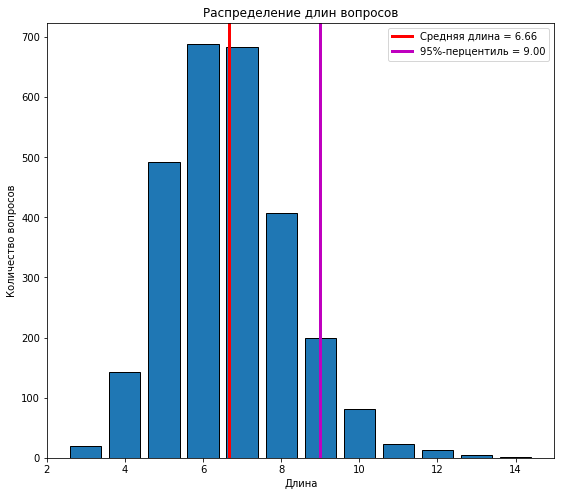

In [20]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.bar(*np.unique(sequences_lenghts, return_counts=True), edgecolor="k")
plt.axvline(np.mean(sequences_lenghts), 
            c="r", lw=3, 
            label="Средняя длина = {:.2f}".format(np.mean(sequences_lenghts)))
plt.axvline(np.percentile(sequences_lenghts, 95), 
            c="m", lw=3, 
            label="95%-перцентиль = {:.2f}".format(np.percentile(sequences_lenghts, 95)))
plt.xlabel("Длина")
plt.ylabel("Количество вопросов")
plt.title("Распределение длин вопросов")
plt.legend()

cut_length = np.round(np.percentile(sequences_lenghts, 95),0)

## Строим векторные представления вопросов

In [21]:
model = Word2Vec([q.split() for q in questions], size=embeddings_dim, window=10,min_count=1)
model.train([q.split() for q in questions],epochs=1000,total_examples=model.corpus_count)
model.most_similar("is")

/home/alex/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/alex/miniconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('was', 0.6335000395774841),
 ('are', 0.5170373320579529),
 ('suit', 0.3929719030857086),
 ('sith', 0.39094293117523193),
 ('exists', 0.37071800231933594),
 ('does', 0.37027475237846375),
 ('revenge', 0.36400991678237915),
 ('religions', 0.3586241602897644),
 ('wallflower', 0.34988218545913696),
 ('perks', 0.3242698311805725)]

In [22]:
q_vectors = pad_sequences(sequences, maxlen=int(cut_length))
print('Размерность тренировочных данных:', q_vectors.shape)

Размерность тренировочных данных: (2756, 9)


In [23]:
embedding_matrix = np.zeros((len(word_index) + 1, embeddings_dim))
for word, i in word_index.items():
    if word in model.wv.vocab:
        embedding_matrix[i] = model[word]

/home/alex/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


## Строим модель

In [24]:
def L2_norm(x):
    return K.l2_normalize(x, axis=1)

In [25]:
q1_input = Input(shape=(cut_length,), 
                dtype="int32", 
                name="QInput")

_embedding_layer = Embedding(input_dim=number_of_words + 1,
                             output_dim=embeddings_dim,
                             input_length=cut_length,
                             weights=[embedding_matrix],
                             trainable=True,
                             mask_zero=False, 
                             name="Embedding")

_conv1d_layer = Conv1D(embeddings_dim,
                       5,
                       activation='relu')

_maxpool1d_layer = GlobalMaxPooling1D()

q1_embedding = _embedding_layer(q1_input)
q1_conv = _conv1d_layer(q1_embedding)
q1_maxpool = _maxpool1d_layer(q1_conv)
q1_normalized = Lambda(function=L2_norm, name="QL2norm")(q1_maxpool)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [26]:
aPath_input = Input(shape=(n_unique_relations,), 
                dtype="float32", 
                name="APathInput")

_dense_layer = Dense(embeddings_dim, input_dim=n_unique_relations+1, activation='relu')

aPath_dense = _dense_layer(aPath_input)

In [27]:
aEntity_input = Input(shape=(n_unique_entities,), 
                dtype="float32", 
                name="AEntityInput")

_dense_layer_entity = Dense(embeddings_dim, input_dim=n_unique_entities+1, activation='relu')

aEntity_dense = _dense_layer_entity(aEntity_input)

In [28]:
added = Add()([aPath_dense, aEntity_dense])

In [29]:
_normalized = Lambda(function=L2_norm, name="AL2norm")(added)

In [30]:
def triplet_loss(args):
    
    q, a = args
    
    def _get_probs():
        # easy negative sampling, i.e. take random from batch
        batch_size = tf.shape(a)[0]
        probs = tf.ones((batch_size, batch_size)) - tf.eye(batch_size, batch_size)
        return probs
    
    def _get_distance(batch1, batch2):
        return 1 - tf.reduce_sum(tf.multiply(batch1, batch2), axis=1)
    
    # margin
    alpha = 0.2
    
    # negative sampling
    probs = _get_probs()
    probs /= tf.reduce_sum(probs, axis=1)
    
    negative_idxs = tf.multinomial(tf.log(probs), 1)
    negs = tf.gather(a, negative_idxs)[:, 0]
    
    # distance calculation
    Dn = _get_distance(q, negs)
    Dp = _get_distance(q, a)
    
    # loss
    loss = tf.reduce_mean(tf.maximum(0.0, Dp - Dn + alpha))
    
    return loss

In [31]:
loss_layer = Lambda(function=triplet_loss, name="Loss")([q1_normalized, _normalized])

In [32]:
model = Model(inputs=[q1_input, aPath_input, aEntity_input], outputs=[loss_layer])

In [33]:
def dummy_loss(y_true, y_pred):
    return y_pred

In [34]:
model.compile(loss=dummy_loss, optimizer="Adam")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
QInput (InputLayer)             (None, 9.0)          0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 9.0, 50)      155550      QInput[0][0]                     
__________________________________________________________________________________________________
APathInput (InputLayer)         (None, 626)          0                                            
__________________________________________________________________________________________________
AEntityInput (InputLayer)       (None, 90704)        0                                            
__________________________________________________________________________________________________
conv1d_1 (

In [35]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Обучаем модель

In [36]:
hist = model.fit([q_vectors, path_vectors,answ_vectors],np.zeros(q_vectors.shape[0]),
                 epochs=25, batch_size=64)

/home/alex/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/25
2756/2756 [==============================] - 6s 2ms/step - loss: 0.1589
Epoch 2/25
2756/2756 [==============================] - 6s 2ms/step - loss: 0.0657
Epoch 3/25
2756/2756 [==============================] - 6s 2ms/step - loss: 0.0429
Epoch 4/25
2756/2756 [==============================] - 7s 3ms/step - loss: 0.0315
Epoch 5/25
2756/2756 [==============================] - 8s 3ms/step - loss: 0.0246
Epoch 6/25
2756/2756 [==============================] - 7s 2ms/step - loss: 0.0213
Epoch 7/25
2756/2756 [==============================] - 8s 3ms/step - loss: 0.0189
Epoch 8/25
2756/2756 [==============================] - 6s 2ms/step - loss: 0.0181
Epoch 9/25
2756/2756 [==============================] - 6s 2ms/step - loss: 0.0150
Epoch 10/25
2756/2756 [==============================] - 6s 2ms/step - loss: 0.0153
Epoch 11/25
2756/2756 [==============================] - 6s 2ms/step - loss: 0.0155
Epoch 12/25
2756/2756 [==============================] - 6s 2ms/step - loss: 0.0152
E

In [39]:
q_model = Model(inputs=[model.get_layer("QInput").input], 
                outputs=[model.get_layer("QL2norm").output])

a_model = Model(inputs=[model.get_layer("APathInput").input,model.get_layer("AEntityInput").input], 
                outputs=[model.get_layer("AL2norm").output])

In [41]:
answers_predicted = a_model.predict([path_vectors,answ_vectors])
questions_predicted = q_model.predict(q_vectors)

In [42]:
knn = NearestNeighbors(n_neighbors=5, 
                 metric="minkowski", 
                 p=2, 
                 n_jobs=-1, 
                 algorithm="kd_tree")
knn.fit(answers_predicted)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [43]:
knn.kneighbors(np.array([questions_predicted[10]]), n_neighbors=5)

(array([[0.44834235, 0.44834235, 0.44834235, 0.44834235, 0.47049035]]),
 array([[1793,  618,   10,  836, 1388]]))

In [44]:
questions[10]

'which countries border the us'

In [48]:
rels[1793]

'/location/location/adjoin_s /location/adjoining_relationship/adjoins '

### Обратный маппинг индекса к ответу